### Imports

In [1]:
%load_ext autoreload
%autoreload 2

from fast_style_transfer_utils import *

imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Restructure dataset in convenient way

In [2]:
content_path = path/'coco-images'/'test2015'
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))
content_path

PosixPath('/home/ec2-user/SageMaker/data/coco-images/test2015')

In [5]:
files = get_files(content_path, image_extensions, recurse=True); len(files)

81434

In [6]:
van_gogh_path = path/'styles'/'VanGogh.png'; van_gogh_path

PosixPath('/home/ec2-user/SageMaker/data/styles/VanGogh.png')

In [7]:
contents = files
styles = [van_gogh_path] * len(contents)

In [9]:
te_ = int(len(styles) * 0.001)
tr_ = len(styles) - te_
assert(len(styles) == (te_+tr_))
print(te_, tr_)
splits = ['valid'] * te_ + ['train'] * tr_ 
shuffle(splits)

81 81353


In [26]:
df = pd.DataFrame({'content_': contents, 'style_': styles, 'split_': splits}); df.head()

,content_,style_,split_
0,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
1,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
2,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
3,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train
4,/home/ec2-user/SageMaker/data/coco-images/test...,/home/ec2-user/SageMaker/data/styles/VanGogh.png,train


In [31]:
style_img = PIL.Image.open(df.sample().style_.iloc[0]); (style_img.size + (3,))

In [13]:
#content_img = PIL.Image.open(df.sample().content_.iloc[0]); content_img

In [34]:
df.to_csv(path/'dataset.csv', index=False)

### FastStyleTransfer

In [4]:
bs = 4
sample = 0.07
size = 256

rgb = MakeRGB()
resized = ResizeFixed(size)
tobyte = ToByteTensor()
tofloat = ToFloatTensor()
norm = Normalize(imagenet_stats)
aug = PilRandomDihedral()

tmfs = [rgb, resized, tobyte, tofloat, norm]

train_ds = StyleTransferDataset(path/'dataset.csv', train_test='train', transform=tmfs, sample=sample)
valid_ds = StyleTransferDataset(path/'dataset.csv', train_test='valid', transform=tmfs, sample=sample)

dataloaders = {'train': DataLoader(train_ds, batch_size=bs, shuffle=True),
              'valid': DataLoader(valid_ds, batch_size=bs)}

Valid dataset: 10 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 256, 256]),'content':torch.Size([3, 256, 256]),'style':torch.Size([3, 256, 256])
Train dataset: 5697 items
Item: <class 'tuple'> of 3 <class 'torch.Tensor'>
Item example: 'input':torch.Size([3, 256, 256]),'content':torch.Size([3, 256, 256]),'style':torch.Size([3, 256, 256])
valid 3


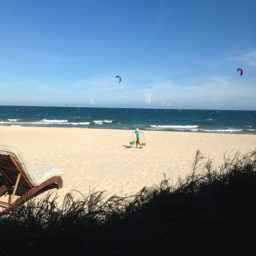

In [5]:
print(valid_ds)
print(train_ds)

datasets = {'train': train_ds, 'valid': valid_ds}
d = random.choice(['train', 'valid'])
i = random.choice(range(len(datasets[d])))
print(d, i)

test_data(dataloaders, datasets, bs, size)
test_deprocess(datasets[d][i])

In [6]:
test_hooks(TransformerNet(), dataloaders, bs)
test_losses(TransformerNet(), dataloaders)

In [30]:
fst = FastStyleTransfer(dataloaders, *get_model_opt(TransformerNet()), style_weight=1e12)

In [31]:
fst.train(num_epochs=1)

Phase: train


batch: 0: (input, content, style) = torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256])
batch: 1000: (input, content, style) = torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256]), torch.Size([4, 3, 256, 256])
phase: train, loss: 4828.761377613776


NameError: name 't' is not defined

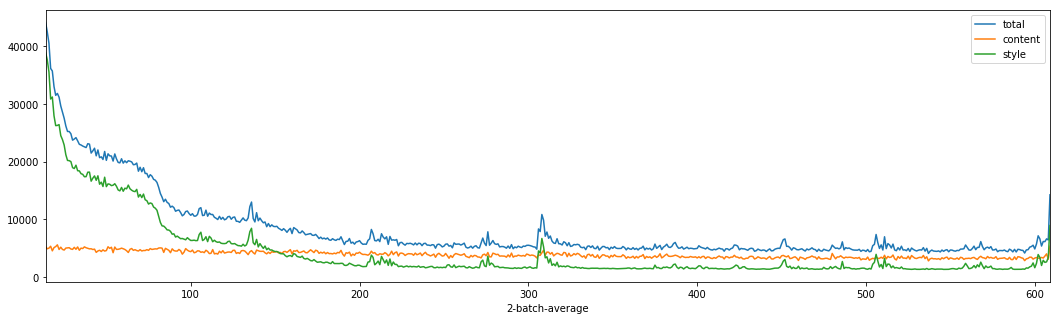

In [34]:
group=2
df = fst.get_metrics('train')
df[f'{group}-batch-average'] = df.batch // group
df = df.groupby(f'{group}-batch-average')['total','content','style'].sum().reset_index()
m = df.total.mean()
s = df.total.std()
df['outlier'] = np.where(df.total < (m+3*s), False, True)

x_axis = min(18, int(0.03*len(df)))
fig, ax = plt.subplots(figsize=(x_axis, 5))
df.loc[df.outlier==False,:].plot(ax=ax, x=f'{group}-batch-average', y=['total', 'content', 'style'])
plt.show()

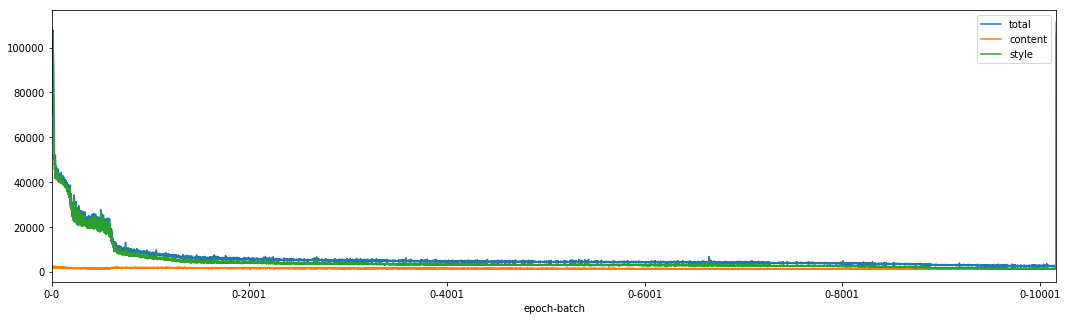

In [49]:
fst.plot_losses('train')

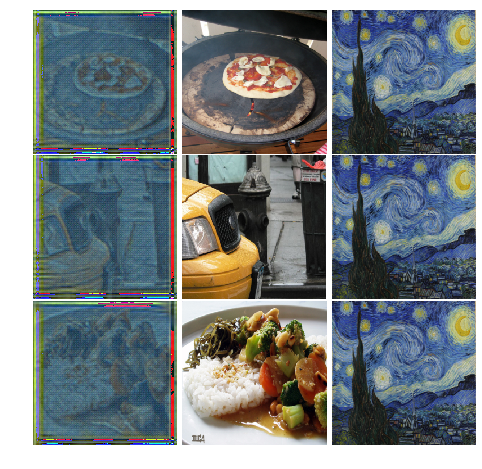

In [35]:
fst.plot_samples('train')

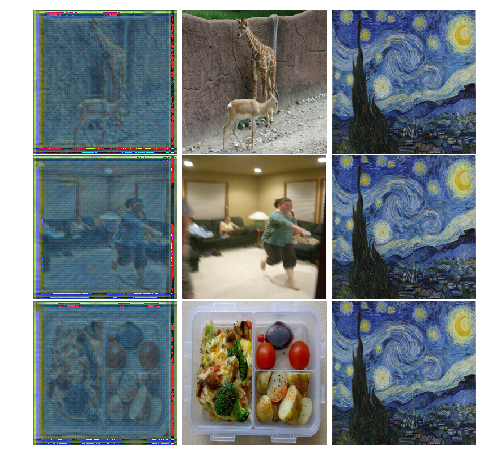

In [36]:
fst.plot_samples('valid')